In [2]:
import wandb
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import importlib
from common import common
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.datasets import fetch_covtype

In [3]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: suyee-tan21 (suyee-tan21-nus). Use `wandb login --relogin` to force relogin


True

In [4]:
# Reload common module
importlib.reload(common)

<module 'common.common' from '/Users/suyeetan/Downloads/CS5344_Project/work/common/common.py'>

In [5]:
# Function to evaluate and print model performance
def evaluate_model(model, X_train, y_train, X_test, y_test):
    seconds = time.time()
    # Train the model
    model.fit(X_train, y_train)
    print("Train operation time: = ",time.time()- seconds ,"seconds")
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Print model evaluation metrics
    common.evaluate(y_test, y_pred, f"\nModel: {model.__class__.__name__}")

In [6]:
# Dictionary to store models and their names
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Support Vector Machine (SVM)": SVC()
}

In [7]:
# project name should correspond to dataset below
# project_name = "covertype"
# project_name = "kdd"
# project_name = "cicids"
# project_name = "thyroid"
# project_name = "unsw"
# project_name = "customer"
# project_name = "satellite"
# project_name = "drug"
# project_name = "mba"
project_name = "tii-ssrc"

In [8]:
if project_name == "covertype":
    %run datasets/covertype.ipynb
    all_df, main_labels, config = get_processed_covtype_df()
elif project_name == "kdd":
    %run datasets/kdd.ipynb
    all_df, main_labels, config = get_processed_kdd_df()
elif project_name == "cicids":
    %run datasets/cicids.ipynb
    all_df, main_labels, config = get_processed_cicids_df()
elif project_name == "thyroid":
    %run datasets/thyroid.ipynb
    all_df, main_labels, config = get_processed_thyroid_df()
elif project_name == "unsw":
    %run datasets/unsw.ipynb
    all_df, main_labels, config = get_processed_unsw_df()
elif project_name == "customer":
    %run datasets/customer.ipynb
    all_df, main_labels, config = get_processed_customer_df()
elif project_name == "satellite":
    %run datasets/satellite.ipynb
    all_df, main_labels, config = get_processed_satellite_df()
elif project_name == "drug":
    %run datasets/drug.ipynb
    all_df, main_labels, config = get_processed_drug_df()
elif project_name == "mba":
    %run datasets/mba.ipynb
    all_df, main_labels, config = get_processed_mba_df()
else:
    %run datasets/tii-ssrc.ipynb
    all_df, main_labels, config = get_processed_tii_ssrc_df()

Normal class:  0    DoS
Name: Traffic Type, dtype: object
numerical_cols ['Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG F

In [9]:
# Should already be one hot encoded and label encoded

TARGET_COLUMN = config['TARGET_COLUMN']
NORMAL_TARGET = config['NORMAL_TARGET']
TARGET_DICT = config['TARGET_DICT']
INV_TARGET_DICT = config['INV_TARGET_DICT']
NUMERICAL_COLUMNS = config['NUMERICAL_COLUMNS']
CATEGORICAL_COLUMNS = config['CATEGORICAL_COLUMNS']
ORDINAL_COLUMNS = config['ORDINAL_COLUMNS']
all_df.head()

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Traffic Type
0,6.0,18921.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
1,6.0,3728459.0,2.0,0.0,100.0,0.0,50.0,50.0,50.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2,6.0,2430207.0,2.0,1.0,100.0,0.0,50.0,50.0,50.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,6.0,14657232.0,2.0,1.0,100.0,0.0,50.0,50.0,50.0,0.0,...,20.0,0.0,0.0,0.0,0.0,14625427.0,0.0,14625427.0,14625427.0,3
4,6.0,10131029.0,2.0,0.0,2712.0,0.0,1356.0,1356.0,1356.0,0.0,...,20.0,0.0,0.0,0.0,0.0,10131029.0,0.0,10131029.0,10131029.0,3


In [10]:
# Get X and y from all_df
X_df = all_df.drop(columns=[TARGET_COLUMN])
y_df = all_df[TARGET_COLUMN]

# Split the data into training and testing sets (80% train, 20% test)
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(1026580, 77) (256645, 77) (1026580,) (256645,)


In [11]:
# Fit and transform the numeric columns
scaler, X_train_scaled_df = common.standardise(X_train_df, NUMERICAL_COLUMNS)
# print('X_train_scaled_df', X_train_scaled_df)

# Use the same scaler to transform X_test
scaler, X_test_scaled_df = common.standardise(X_test_df, NUMERICAL_COLUMNS, scaler=scaler)
# print('X_test_scaled_df', X_test_scaled_df)

/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train operation time: =  973.5631527900696 seconds

Model: LogisticRegression


/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

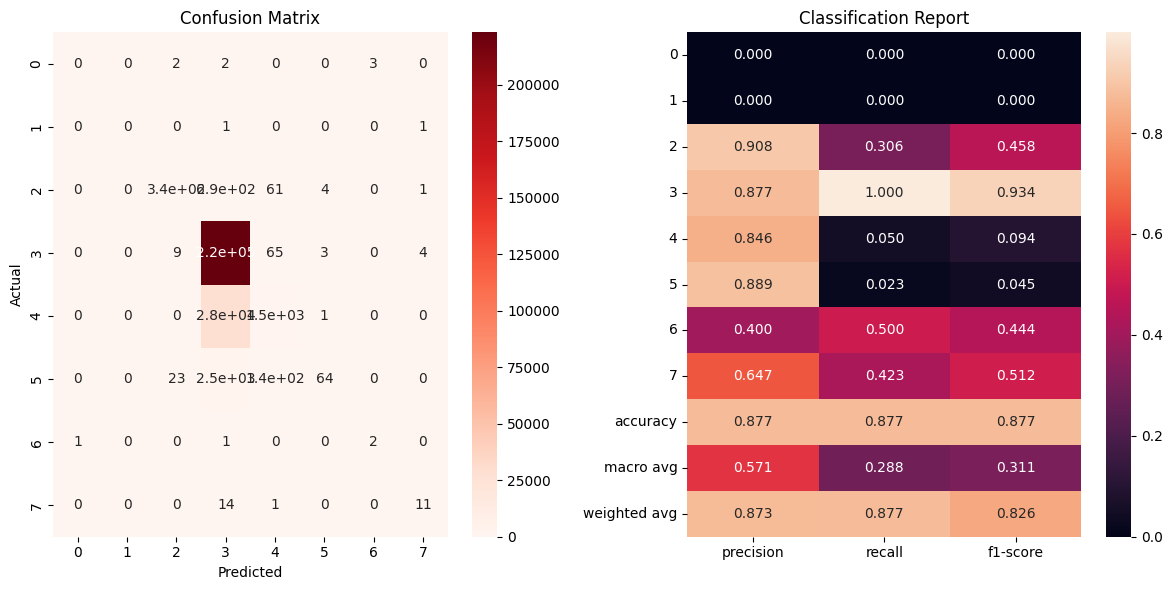

Accuracy: 0.8765843869937072


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.87658
f1-score_avg,0.82569
precision_avg,0.8734
recall_avg,0.87658


Train operation time: =  39.83056306838989 seconds

Model: DecisionTreeClassifier


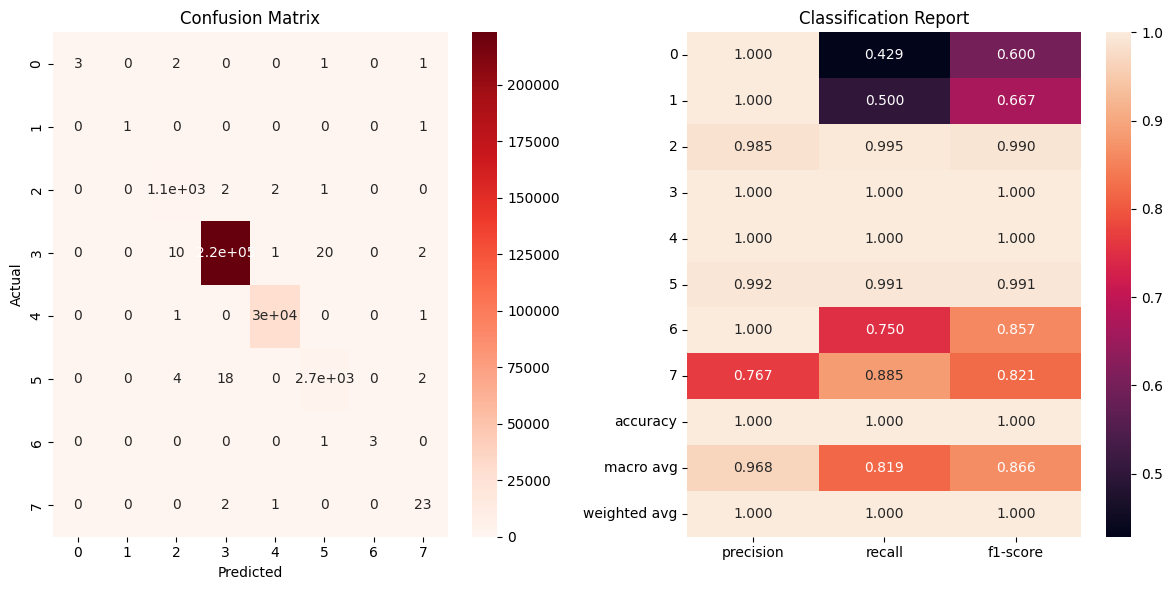

Accuracy: 0.9997155604044498


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.99972
f1-score_avg,0.99971
precision_avg,0.99972
recall_avg,0.99972


Train operation time: =  221.04744815826416 seconds

Model: RandomForestClassifier


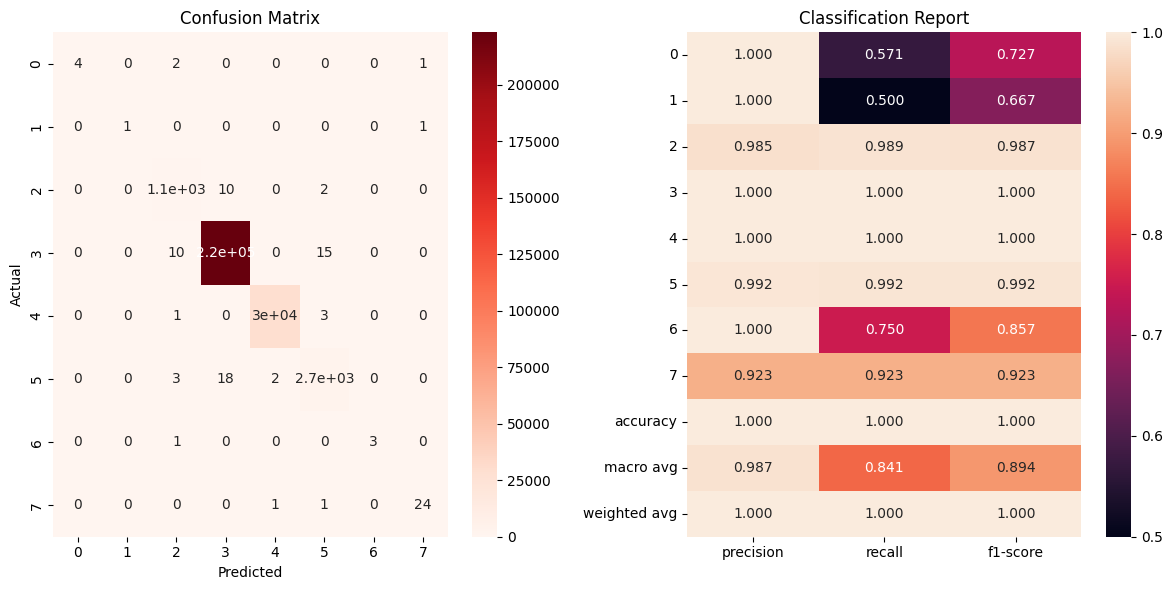

Accuracy: 0.9997233532700812


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.99972
f1-score_avg,0.99972
precision_avg,0.99972
recall_avg,0.99972


In [ ]:
# Loop through models and evaluate each one
project_name = "baseline-" + project_name
seconds = time.time()
for model_name, model in models.items():
    wandb.init(project=project_name, name=model_name)
    
    # For SVM and Logistic Regression, use scaled data
    if model_name in ["Logistic Regression", "Support Vector Machine (SVM)"]:
        evaluate_model(model, X_train_scaled_df, y_train_df, X_test_scaled_df, y_test_df)
    else:
        evaluate_model(model, X_train_df, y_train_df, X_test_df, y_test_df)
        
    wandb.finish()
print("Total operation time: = ", time.time() - seconds, "seconds")

In [ ]:
wandb.finish()